In [1]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
import shap
import matplotlib.pyplot as plt

C:\Users\Tevhidenur\anaconda3n\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Metadata Ön İşleme
metadata_path = 'cleaned_movies4.csv'
metadata_df = pd.read_csv(metadata_path)

# Poster isimlerini normalize etme
def clean_filename(title):
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title)  # Özel karakterleri kaldır (- ve ' hariç)
    return title

metadata_df['Poster_Filename'] = metadata_df['Title'].apply(clean_filename) + '_' + metadata_df['Year'].astype(str) + '.jpg'

In [3]:
# 2. Poster İşleme
poster_folder = 'posters'
image_size = (224, 224)

# Görüntüleri işleme ve normalize etme
X_images = []
for filename in metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder, filename)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size)
        img = np.array(img) / 255.0  # Normalize [0,1]
        X_images.append(img)
    else:
        print(filename)
        X_images.append(np.zeros((*image_size, 3)))  # Eksik posterler için boş resim

X_images = np.array(X_images)

In [4]:
# 3. Metadata İşleme
# Sayısal sütunlar
numerical_features = ['Runtime(min)', 'Budget']
X_numeric = metadata_df[numerical_features].values

# Kategorik sütunları encode etme
categorical_features = ['Director', 'Country', 'Genre1', 'Genre2', 'Genre3', 'Actor1', 'Actor2', 'Actor3']
encoders = {}
X_categorical = []
for feature in categorical_features:
    le = LabelEncoder()
    metadata_df[feature] = le.fit_transform(metadata_df[feature])
    X_categorical.append(metadata_df[feature].values)
    encoders[feature] = le

X_categorical = np.column_stack(X_categorical)

# Bağımlı değişken (Y)
Y = metadata_df['BoxOffice'].values

In [5]:
# Eğitim ve Test Verisi Ayırma
X_img_train, X_img_test, X_num_train, X_num_test, X_cat_train, X_cat_test, Y_train, Y_test = train_test_split(
    X_images, X_numeric, X_categorical, Y, test_size=0.2, random_state=42)

In [6]:
# Modelleme Aşaması
# 1. EfficientNetB0 Modeli
image_input = layers.Input(shape=(224, 224, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)

In [7]:
# 2. Metadata için MLP
metadata_input = layers.Input(shape=(X_numeric.shape[1] + X_categorical.shape[1],))
y = layers.Dense(128, activation='relu')(metadata_input)
y = layers.Dense(64, activation='relu')(y)

In [8]:
# 3. Birleştirme ve Çıkış Katmanı
combined = layers.concatenate([x, y])
output = layers.Dense(1)(combined)

In [9]:
# Modelin Tanımlanması
model = models.Model(inputs=[image_input, metadata_input], outputs=output)
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [10]:
# Model Eğitimi
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_img_train, np.hstack([X_num_train, X_cat_train])], Y_train,
                    validation_data=([X_img_test, np.hstack([X_num_test, X_cat_test])], Y_test),
                    epochs=50, batch_size=32, callbacks=[callback])

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 846ms/step - loss: 19336108122832896.0000 - mae: 79176920.0000 - val_loss: 6873800951988224.0000 - val_mae: 50556652.0000
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 821ms/step - loss: 7318253294583808.0000 - mae: 48730296.0000 - val_loss: 3243687882522624.0000 - val_mae: 37853768.0000
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 829ms/step - loss: 5872144785342464.0000 - mae: 48535932.0000 - val_loss: 3341669776752640.0000 - val_mae: 38547772.0000
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 938ms/step - loss: 5222436492541952.0000 - mae: 46068640.0000 - val_loss: 3336010083598336.0000 - val_mae: 38511248.0000
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 907ms/step - loss: 5904802106048512.0000 - mae: 48654656.0000 - val_loss: 3191022188232704.0000 - val_mae: 37423344.0000
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 885ms/step - loss: 5042363009335296.0000 - mae: 44265168.0000 - val_loss: 3431648536297472.0000 - val_mae: 39090696.0000
Epoch 7/50
37/37 ━━━━

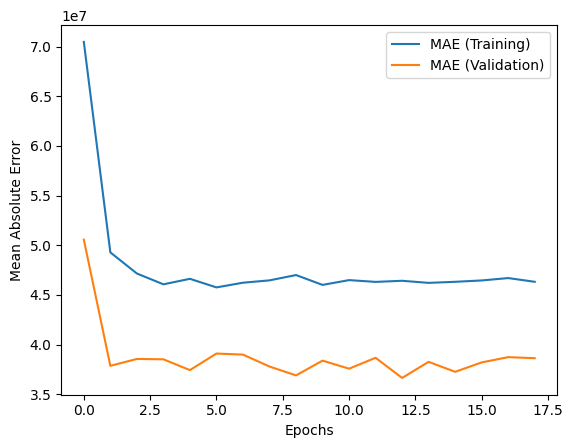

In [11]:
# Performans Analizi
plt.figure()
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
# SHAP Analizi
explainer = shap.Explainer(model, [X_img_test, np.hstack([X_num_test, X_cat_test])])
shap_values = explainer([X_img_test, np.hstack([X_num_test, X_cat_test])])
shap.summary_plot(shap_values, features=np.hstack([X_num_test, X_cat_test]))

print("Model eğitimi ve analizi tamamlandı.")